# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [35]:
# These libraries may be useful to you

# !pip install pyLDAvis==3.4.1 --user  #You need to restart the Kernel after installation.
# You also need a Python version => 3.9.0
from nltk.corpus import brown
# import nltk
# nltk.download('brown')

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords
import en_core_web_sm

from collections import Counter, defaultdict

nlp = en_core_web_sm.load()

In [36]:
# add any additional libaries you need here



In [37]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [38]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [39]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [40]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


<Axes: xlabel='category'>

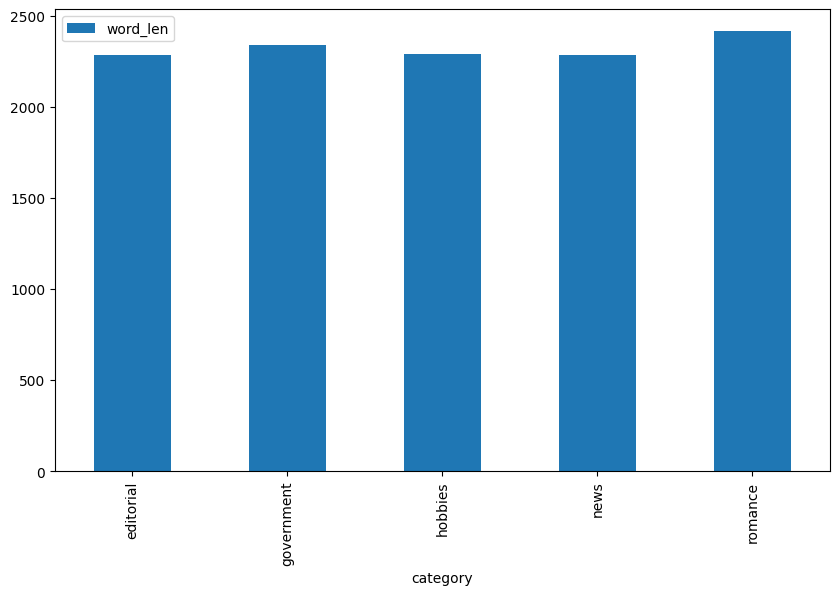

In [41]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [42]:
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

/Users/kevinbaum/ENTER/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(166, 4941)

In [43]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: The two data frames `count_text_vectors` and `tfidf_text_vectors` represent numerical representations of the documents that have been transformed by Count Vectorization and TF-IDF. Count Vectorization turns the text into a matrix of token counts, and we used the parameters min_df=5 and max_df=0.7 to exclude tokens appearing in fewer than 5 documents for being too rare and more than 70% of documents for being too common to be significant. TF-IDF, or Term Frequency-Inverse Document Frequency Vectorization, is a way quantify the importance of a word in a document relative to the corpus we are using. It calculates the term frequency, the inverse document frequency, then multiplies them to get the TF-IDF score.

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [44]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [45]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.39)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.63)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.02)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF factorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


In [46]:
# Assign the highest topic to each document
df['nmf_topic'] = W_text_matrix.argmax(axis=1)

# Tally the Brown categories for each NMF topic
topic_category_counts = df.groupby('nmf_topic')['category'].value_counts().unstack(fill_value=0)

# Display the tallied counts
print(topic_category_counts)

category   editorial  government  hobbies  news  romance
nmf_topic                                               
0                 20           4        0     8        0
1                  4           0        8     0       29
2                  2          26       26    11        0
3                  0           0        1    17        0
4                  1           0        1     8        0


Q: How does your five-topic NMF model compare to the original Brown categories? 

A: Looking at the NMF model vs the original Brown categories, we find some mixed results. Starting with "most aligned," Topic 1 seems to have identified the romance genre particularly well. It contains 4 documents from editorial, 8 from hobbies, and 29 from romance. So we see that there is a little bit of a mixed bag, but the romance genre is not assigned anywhere else, so the model has done a really good job identifying it. Topics 3 and 4 have identified news articles particuarly well, containing little else besides news. However, there is only supposed to be 1 news topic, so this is not very informative. Topic 0 contains mostly editorial with a few government and news as well.

Topic 2, on the other hand, contains a large proportion of government, hobbies, and to a lesser extent, news. This obscures the results, because if we are trying to figure out which topic corresponds to which category, it is difficult to discern the difference between government and hobbies. This tells us that perhaps the language between government and hobbies is similar enough not to be simply deduced by the model. It will be interesting to see how the other models figure out this difference. 

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [47]:
# Fit the LSA model
lsa_model = TruncatedSVD(n_components=5, random_state=314)
W_text_matrix_lsa = lsa_model.fit_transform(tfidf_text_vectors)

# Assign topics to documents
df['lsa_topic'] = W_text_matrix_lsa.argmax(axis=1)

# Tally the original categories for each LSA topic
topic_category_counts_lsa = df.groupby('lsa_topic')['category'].value_counts().unstack(fill_value=0)
print(topic_category_counts_lsa)

category   editorial  government  hobbies  news  romance
lsa_topic                                               
0                 27          30       36    34       21
1                  0           0        0     0        8
3                  0           0        0     3        0
4                  0           0        0     7        0


Q: How does your five-topic LSA model compare to the original Brown categories? 

A: In contrast to the NMF model, the LSA model captures most of the categories from the Brown dataset in topic 0. There is not much of a distribution across the topics. In fact, it appears that topic 2 does not even contain one. Topics 1, 3, and 4 have very narrow representation, and they capture some of the other Brown categories. Similar to the NMF model, the LSA model is able to group romance by itself in topic 1. Having said that, most of the romance ones are still in topic 0. Likewise, topics 3 and 4 capture some of the news categories, but news is nonetheless predominantly represented in topic 0. 

In [48]:
# call display_topics on your model

# Display the topics
features = tfidf_text_vectorizer.get_feature_names_out()
display_topics(lsa_model, features)


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.12)
  mr (1.70)
  said (1.06)
  kennedy (0.82)
  khrushchev (0.77)

Topic 03
  mrs (29.45)
  club (6.53)
  game (6.12)
  jr (5.60)
  university (5.20)

Topic 04
  game (4.54)
  league (3.27)
  baseball (3.22)
  ball (3.10)
  team (2.94)


Q: What is your interpretation of the display topics output? 

A: Going into this question, I am a little biased in thinking that Topic 01 is probably romance. Both the NMF and LSA models seemed queued into putting romance in topic 1. It is not necessarily obvious, however, based on the display topics that this is the case. Topic 1 contains "said", "ll", "didn", "thought", and "got." These are all very broad words. Other topics, however, are a little more obvious. Take topic 2 for example. We know that one of the topics is government, and this topic contains both Kennedy and Krushchev, who were famous politicians of the mid-late 20th century. Now, whether this is government, news, or editorial is up for debate, but it is almost assuredly NOT hobbies or romance. Topic 4 contains elements of baseball/sports. This could be either editorial, news, or hobbies. Most likely, however, it is editorial or news. Topic 3 looks like it could be either editorial or hobbies talking about club, game, and university. Topic 0 is very vague, akin to it topic 1. It is difficult to make comments about it for that reason. 

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [49]:
# Fit your LDA model here

# Fit the LDA model
lda_model = LatentDirichletAllocation(n_components=5, random_state=314, learning_method='batch')
lda_text_model = lda_model.fit(count_text_vectors)

In [50]:
# Call `display_topics` on your fitted model here
display_topics(lda_model, count_text_vectorizer.get_feature_names_out())


Topic 00
  said (1.05)
  mrs (0.82)
  little (0.56)
  good (0.51)
  way (0.50)

Topic 01
  state (0.67)
  development (0.63)
  000 (0.57)
  program (0.48)
  business (0.44)

Topic 02
  said (1.18)
  mr (0.72)
  president (0.51)
  city (0.43)
  state (0.37)

Topic 03
  feed (0.55)
  college (0.54)
  general (0.44)
  university (0.43)
  work (0.37)

Topic 04
  states (1.14)
  state (1.02)
  united (0.84)
  shall (0.66)
  government (0.61)


Q: What inference do you draw from the displayed topics for your LDA model? 

A: This time for topic 0, we have a few more descriptive words than in the LSA model. "Little", "good", and "way" are somewhat more descriptive, but still offer no conclusive insight. For topic 1, we have a much different result than before. Rather than seeming like it is capturing romance, the topic seems more aligned with news or government. Topic 2 is not too unlike topic 1 here where it could be either news or government. Topic 3 is most likely hobbies or editorial, as it spans multiple different themes such as "college" and "work." Topic 4 is back to seeming either like news or government. Overall, it still is not very clear which Brown category each topic represents. 

In [51]:
# Setting up the below code to tally topics for the Brown categories.
doc_topic_distributions = lda_text_model.transform(count_text_vectors)
df['lda_topic'] = doc_topic_distributions.argmax(axis=1)

# For the next question: tally the original Brown categories for each LDA topic
topic_category_counts_lda = df.groupby('lda_topic')['category'].value_counts().unstack(fill_value=0)
print(topic_category_counts_lda)

category   editorial  government  hobbies  news  romance
lda_topic                                               
0                  3           1       11     4       28
1                  1          12        9     3        0
2                 21           3        2    32        1
3                  2           4        8     3        0
4                  0          10        6     2        0


Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

A: This time, we have a lot of variability across the topic. Instead of romance being concentrated in topic 1, it is in topic 0 this time, with a smattering of other topics throughout topic 0 as well. Hobbies is the second most accounted for category in topic 0, and indeed it is its highest representation throughout. Topic 1 contains a mix of government and hobbies, and government is also highly represented in topic 4. Topic 2 contains both editorial and news. The model seems to have a hard time making decisions on editorial vs news since they are roughly similar. We have seen it in all of our models so far and this one is no different. Topic 3 contains hobbies in the majority, but it is still not as highly represented as it was in topic 0. 

In [52]:
lda_display = pyLDAvis.lda_model.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

In [53]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: Starting with the principal component scatterplot, we see that the topic circles are set up in such a way that PC1 is very far from the rest while PC2 and PC4 are relatively close together. This indicates that the topics for 2 and 4 are more similar to each other than the rest of them are to one another. PC1, especially, has topics that are very different from everything else, with its closest relative being PC3. All the bubbles are about equidistant from PC3, indicating that PC3 shares some similarities with all of them. PC3 is also the biggest, indicating that it is the most prevalent topic in the corpus. This is because the size corresponds to the proportion of the corpus that the topics cover. 

Moving to the salient terms graph, this graph is used to show the top 30 most salient terms across the topics identified by the LDA model. We see that the word "said" is the most salient term, followed by state and then states. This means that these terms are prominent in the corpus, so they are important in the context of the topics. We see some other terms that we might expect when talking about the topics. For example, the word "rhode" almost assuredly refers to "Rhode Island" and is talking about some event occurring in that state. Words like "united" and "states" inicate we are probably talking about the United States of America. 
